In [60]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import keras.callbacks
from keras.callbacks import TensorBoard
from pathlib import Path
import glob

In [3]:
 from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
train_data_dir = '/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_data_dir = '/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Test'


In [5]:
data_dir_train = pathlib.Path(train_data_dir)
data_dir_test = pathlib.Path(test_data_dir)

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [7]:
### Load using keras.preprocessing

# Let's load these images off disk using the helpful image_dataset_from_directory utility.
from keras.preprocessing.image import ImageDataGenerator


In [8]:
### Create a dataset

# Define some parameters for the loader:

In [9]:
# Use 80% of the images for training, and 20% for validation.

In [10]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (180, 180)
input_shape = ()

In [11]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=0/1, validation_split=0.2)

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [15]:
### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

train_ds
val_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

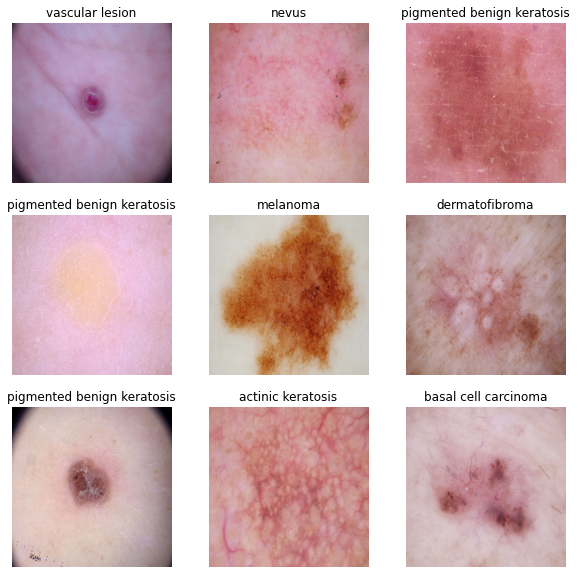

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
from tensorflow.keras import layers

n_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [20]:
n_ds = train_ds.map(lambda x, y: (n_layer(x), y))
image_batch, labels_batch = next(iter(n_ds))
n_ds

<MapDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [21]:
### Compile the model
# Choose an appropirate optimiser and loss function for model training 
num_classes = 9

# model
model = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
input_shape =(180, 180, 1)

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [23]:
epochs =20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

history = model.fit(
        train_ds,
        #steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=val_ds,
        #validation_steps=nb_validation_samples // batch_size,
        callbacks=callbacks
    )

Epoch 1/20
56/56 [==============================] - 100s 2s/step - loss: 1.9868 - accuracy: 0.2606 - val_loss: 2.0600 - val_accuracy: 0.2371
Epoch 2/20
56/56 [==============================] - 64s 1s/step - loss: 1.7712 - accuracy: 0.3393 - val_loss: 1.6718 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 64s 1s/step - loss: 1.5530 - accuracy: 0.4425 - val_loss: 1.5590 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 65s 1s/step - loss: 1.4146 - accuracy: 0.5000 - val_loss: 1.4052 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 64s 1s/step - loss: 1.3150 - accuracy: 0.5407 - val_loss: 1.4440 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 64s 1s/step - loss: 1.2567 - accuracy: 0.5536 - val_loss: 1.3620 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 65s 1s/step - loss: 1.1972 - accuracy: 0.5681 - val_loss: 1.3955 - val_accuracy: 0.5011
Epoch 8/20
56/56 [=

In [24]:
# evaluate the model on test data just checking
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)


Found 118 files belonging to 9 classes.


In [25]:
model.evaluate(test_ds)

4/4 [==============================] - 25s 253ms/step - loss: 5.2055 - accuracy: 0.3644


[5.205532073974609, 0.3644067943096161]

In [26]:
print(model.metrics_names)

['loss', 'accuracy']


In [27]:
# validation accuracy is low compared to the training accuracy, indicating our model is overfitting

In [28]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)       

In [29]:
### Visualizing training results

In [30]:
history_dict = model.history.history
print(history_dict.keys())

dict_keys([])


In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

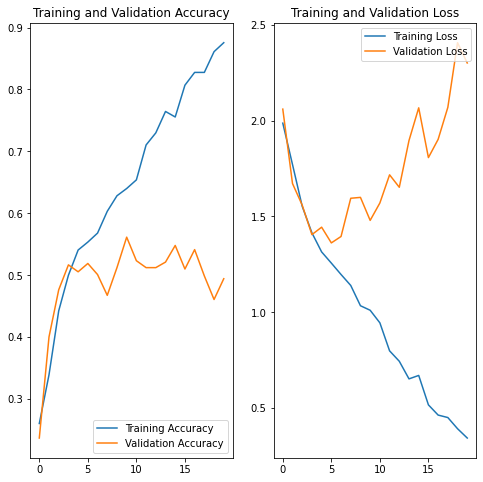

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# validation accuracy is low compared to the training accuracy, indicating our model is overfitting

In [34]:
## Using image data augmentation to build the 2nd model

In [35]:
data_augmentation = tf.keras.Sequential([
  #layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [36]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [37]:
num_classes = 9

model_2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [38]:
model_2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [39]:
epochs =20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

history_2 = model_2.fit(
        train_ds,
        #steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=val_ds,
        #validation_steps=nb_validation_samples // batch_size,
        callbacks=callbacks
    )

Epoch 1/20
56/56 [==============================] - 70s 1s/step - loss: 2.0267 - accuracy: 0.2394 - val_loss: 2.0466 - val_accuracy: 0.1969
Epoch 2/20
56/56 [==============================] - 69s 1s/step - loss: 1.7559 - accuracy: 0.3689 - val_loss: 1.5882 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 69s 1s/step - loss: 1.6270 - accuracy: 0.4124 - val_loss: 1.5701 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 68s 1s/step - loss: 1.5574 - accuracy: 0.4336 - val_loss: 1.5760 - val_accuracy: 0.4407
Epoch 5/20
56/56 [==============================] - 68s 1s/step - loss: 1.4755 - accuracy: 0.4704 - val_loss: 1.4454 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 68s 1s/step - loss: 1.4055 - accuracy: 0.5123 - val_loss: 1.3726 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 68s 1s/step - loss: 1.3916 - accuracy: 0.5056 - val_loss: 1.4199 - val_accuracy: 0.5168
Epoch 8/20
56/56 [==

In [40]:
# View the summary of all layers
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 32)       

In [41]:
# Visualize errors
history_dict = model_2.history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [42]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

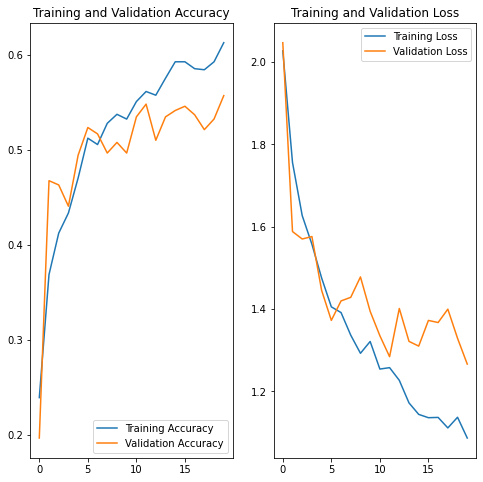

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
# Though the overfittig problem is solved, the accuracy has significantly decreased, so we have to see if there is a class imbalace and that can improve the model accuracy

In [45]:
# Count number of files in the classes

import os
ROOT_PATH = '/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
class_names
#print(len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH))))

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [46]:
for x in class_names:
  print(x)
  print(len(os.listdir(os.path.join(ROOT_PATH, x))))
  print('-------------------------------------------')


actinic keratosis
114
-------------------------------------------
basal cell carcinoma
376
-------------------------------------------
dermatofibroma
95
-------------------------------------------
melanoma
438
-------------------------------------------
nevus
357
-------------------------------------------
pigmented benign keratosis
462
-------------------------------------------
seborrheic keratosis
77
-------------------------------------------
squamous cell carcinoma
181
-------------------------------------------
vascular lesion
139
-------------------------------------------


In [47]:
# - Which class has the least number of samples? - seborrheic keratosis
# - Which classes dominate the data in terms proportionate number of samples? - pigmented benign keratosis

In [48]:
!pip install Augmentor

In [53]:
path_to_training_dataset="C:\\Pooja\\DS\\5- Deep Learning\CNN assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train"
import Augmentor

for labels in class_names:
    print(train_data_dir + '/'+labels)
    p = Augmentor.Pipeline(train_data_dir + '/'+labels)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB59CCEC8D0>:   0%|          | 1/500 [00:00<01:16,  6.51 Samples/s]

Initialised with 114 image(s) found.
Output directory set to /gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB59DC91ED0>: 100%|██████████| 500/500 [00:20<00:00, 24.14 Samples/s]


/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB59754C910>: 100%|██████████| 500/500 [00:21<00:00, 23.74 Samples/s]


/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB59D1F6D50>: 100%|██████████| 500/500 [00:22<00:00, 22.06 Samples/s]


/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB59CCF5050>: 100%|██████████| 500/500 [01:39<00:00,  5.00 Samples/s]


/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FB59758F850>: 100%|██████████| 500/500 [01:38<00:00,  5.10 Samples/s]


/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB597617B10>:   0%|          | 1/500 [00:00<01:16,  6.50 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB597621590>: 100%|██████████| 500/500 [00:20<00:00, 23.91 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB59DC0A350>: 100%|██████████| 500/500 [00:48<00:00, 10.23 Samples/s]


/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB59D158E90>:   0%|          | 1/500 [00:00<01:15,  6.61 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB59D158B90>: 100%|██████████| 500/500 [00:20<00:00, 23.97 Samples/s]


/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB59CCDE9D0>: 100%|██████████| 500/500 [00:21<00:00, 23.31 Samples/s]


In [58]:
data_dir_train= train_data_dir 
path = Path(data_dir_train)
image_count_train = len(list(path.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [63]:
path_list = list(path.glob('*/output/*.jpg'))

In [64]:
print(path_list)

[PosixPath('/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_c402ca1d-a68b-46bc-9d10-e6bf9fbbf584.jpg'), PosixPath('/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_4277e361-7292-44a4-a8bc-f3eab3613e21.jpg'), PosixPath('/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030655.jpg_150b14d6-3646-42d6-8010-7e3c8686d68c.jpg'), PosixPath('/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_4f64879f-52bf-4dd9-b8cf-a7dc2e0e5a00.jpg'), PosixPath('/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic kera

In [77]:
path_new = Path(data_dir_train)
print(data_dir_train)
image_count_train_new = len(list(path_new.glob('*.*')))
print(image_count_train_new)

/gdrive/My Drive/CNN-Images/Skin cancer ISIC The International Skin Imaging Collaboration/Train
0


In [78]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_new,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [80]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_new,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [82]:
### Compile the model
# Choose an appropirate optimiser and loss function for model training 
num_classes = 9

# model
model_3 = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
input_shape =(180, 180, 1)

model_3 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [81]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [83]:
model_3.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [84]:
epochs =30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

history_3 = model_3.fit(
        train_ds,
        #steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=val_ds,
        #validation_steps=nb_validation_samples // batch_size,
        callbacks=callbacks
    )

Epoch 1/30
169/169 [==============================] - 229s 1s/step - loss: 1.8020 - accuracy: 0.3179 - val_loss: 1.5014 - val_accuracy: 0.4165
Epoch 2/30
169/169 [==============================] - 194s 1s/step - loss: 1.3983 - accuracy: 0.4805 - val_loss: 1.3239 - val_accuracy: 0.5115
Epoch 3/30
169/169 [==============================] - 194s 1s/step - loss: 1.2213 - accuracy: 0.5538 - val_loss: 1.2154 - val_accuracy: 0.5160
Epoch 4/30
169/169 [==============================] - 194s 1s/step - loss: 1.0321 - accuracy: 0.6276 - val_loss: 1.0639 - val_accuracy: 0.6147
Epoch 5/30
169/169 [==============================] - 194s 1s/step - loss: 0.8919 - accuracy: 0.6825 - val_loss: 1.0047 - val_accuracy: 0.6281
Epoch 6/30
169/169 [==============================] - 194s 1s/step - loss: 0.6965 - accuracy: 0.7524 - val_loss: 0.7929 - val_accuracy: 0.7275
Epoch 7/30
169/169 [==============================] - 194s 1s/step - loss: 0.5335 - accuracy: 0.8105 - val_loss: 0.8299 - val_accuracy: 0.7209

In [85]:
# View the summary of all layers
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 20, 32)       

In [87]:
history_dict = model_3.history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [89]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

In [90]:
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

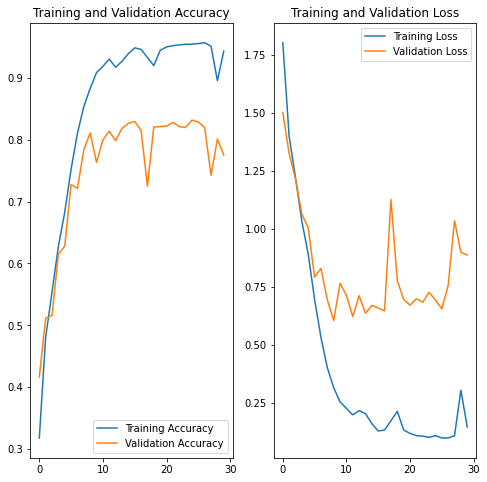

In [91]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [92]:
# We have improved a lot after the third model as the training & validation accuracies are much more better than the 2nd model and we have resolved overfitting problem also.